In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

In [2]:
def showModulesInPlane(plane,side,geom_df,ax,color='gray'):

    """
    overlays the contours of the modules from the baseline geometry file
    """
    
    mask_sector = (geom_df['plane'] == plane)
    for row in geom_df[mask_sector].itertuples(index=False):
        vx = np.array([getattr(row, f'vx_{i}') for i in range(0, 6)])
        vy = np.array([getattr(row, f'vy_{i}') for i in range(0, 6)])
        radius = np.sqrt(vx*vx + vy*vy)
        vx = np.concatenate([vx[radius > 0], vx[0:1]])
        vy = np.concatenate([vy[radius > 0], vy[0:1]])
        
        #for these layers a 30deg rotation must be applied
        if plane in [28,30,32]:
            dphi=-np.pi/6.
            rvx=vx*np.cos(dphi)-vy*np.sin(dphi)
            rvy=vx*np.sin(dphi)+vy*np.cos(dphi)
            vx=rvx
            vy=rvy
            
        ax.plot(vx*(1 if side<0 else -1), vy, color=color)
        
        #complete for the other quadrants
        for i in range(1,3):
            dphi=i*np.pi*2/3
            rvx=vx*np.cos(dphi)-vy*np.sin(dphi)
            rvy=vx*np.sin(dphi)+vy*np.cos(dphi)
            ax.plot(rvx*(1 if side<0 else -1), rvy, color=color)
            
            
def getCorrectedFullGeometry(geom_df):
    
    z=[
        3221.455, 3231.76,  3252.025, 3262.33,  3282.595,
        3292.9,   3313.165, 3323.47,  3343.735, 3354.04,
        3374.305, 3384.61,  3404.875, 3415.18,  3435.445, 
        3445.75,  3466.015, 3476.32,  3499.835, 3510.14,  
        3533.655, 3543.96,  3567.475, 3577.78,  3601.295, 
        1640.2,   3677.495, 3740.545, 3803.595, 3866.645, 
        3929.695, 3992.745, 4055.795, 4118.845, 4181.895, 
        4244.945, 4307.995, 4390.245, 4472.495, 4554.745,
        4636.995, 4719.245, 4801.495, 4883.745, 4965.995, 
        5048.245, 5130.495
    ]    
    
    corr_geom_df=[]
    
    for irow,row in geom_df.iterrows():

        plane=row['plane']
        nvertices=row['nvertices']
        vx = np.array([getattr(row, f'vx_{i}') for i in range(0, 7)])
        vy = np.array([getattr(row, f'vy_{i}') for i in range(0, 7)])        
        
        #rotated planes
        if plane in [28,30,32]:
            radius = np.sqrt(vx*vx + vy*vy)        
            dphi=-np.pi/6.
            rvx=vx*np.cos(dphi)-vy*np.sin(dphi)
            rvy=vx*np.sin(dphi)+vy*np.cos(dphi)
            vx=rvx
            vy=rvy 
            
        corr_geom_df.append( [plane,-z[plane-1],nvertices]+vx.tolist()+vy.tolist() )
        
        #add copies for the other sectors
        for i in range(1,3):
            dphi=i*np.pi*2/3
            rvx=vx*np.cos(dphi)-vy*np.sin(dphi)
            rvy=vx*np.sin(dphi)+vy*np.cos(dphi)
            corr_geom_df.append( [plane,-z[plane-1],nvertices]+rvx.tolist()+rvy.tolist() )
                
    return pd.DataFrame(corr_geom_df,
                       columns=['plane','z','nvertices']+[f'vx_{i}' for i in range(0,7)]+[f'vy_{i}' for i in range(0,7)])

geom_df=pd.read_csv('../data/geometry.hgcal.txt', sep='\s+', comment='#', header='infer')
corr_geom_df=getCorrectedFullGeometry(geom_df) #negative side geometry
corr_geom_df.head()

plane         z  nvertices        vx_0        vx_1        vx_2        vx_3  \
0      1 -3221.455          5  -83.718000  -83.729000   83.695000   83.705000   
1      1 -3221.455          5 -251.200533 -232.300090 -315.999966 -334.899908   
2      1 -3221.455          5  334.918533  316.029090  232.304966  251.194908   
3      1 -3221.455          6    0.047000   -0.018000  -83.763000 -167.442000   
4      1 -3221.455          6 -334.899935 -418.599967 -418.599796 -334.900092   

         vx_4        vx_5        vx_6        vy_0        vy_1        vy_2  \
0    0.047000  -83.718000    0.000000  338.396000  316.578000  316.564000   
1 -334.899935 -251.200533   -0.000000 -241.699915 -230.800441  -85.800004   
2  334.852935  334.918533    0.000000  -96.696085  -85.777559 -230.763996   
3 -167.463000  -83.718000    0.047000  386.682000  483.368000  531.718000   
4 -251.200361 -251.200533 -334.899935 -193.300297 -241.699588 -338.399886   

         vy_3        vy_4        vy_5        vy_6  
0  338.382000  386.682000  338.396000    0.000000  
1  -96.700344 -193.300297 -241.699915    0.000000  
2 -241.681656 -193.381703  -96.696085   -0.000000  
3  483.382000  386.746000  338.396000  386.682000  
4 -386.700026 -338.400212 -241.699915 -193.300297

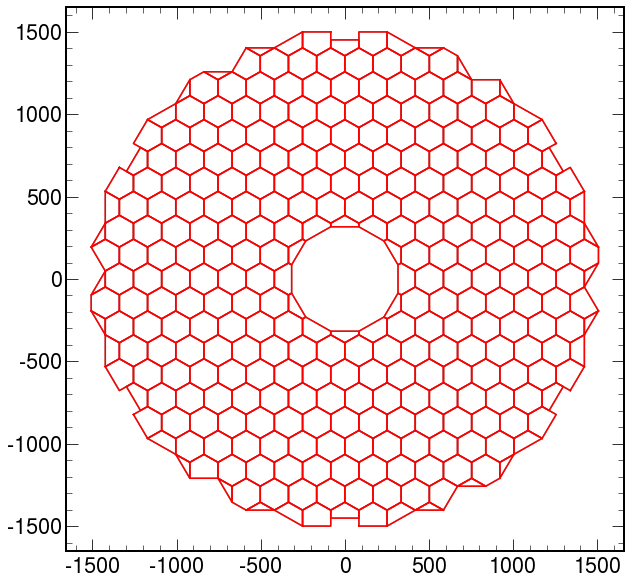

In [3]:
layer=1
side=-1
fig,ax=plt.subplots(figsize=(10,10))
showModulesInPlane(layer,side,geom_df,ax)
for irow,row in corr_geom_df[corr_geom_df['plane']==layer].iterrows():
    vx = np.array([getattr(row, f'vx_{i}') for i in range(0, 7)])
    vy = np.array([getattr(row, f'vy_{i}') for i in range(0, 7)])
    radius = np.sqrt(vx*vx + vy*vy)
    vx = np.concatenate([vx[radius > 0], vx[0:1]])
    vy = np.concatenate([vy[radius > 0], vy[0:1]])    
    ax.plot(vx, vy, color='red')
plt.show()

## 1. Point-in-polygon problem
Test if a point is within a polygon (hexaboard)

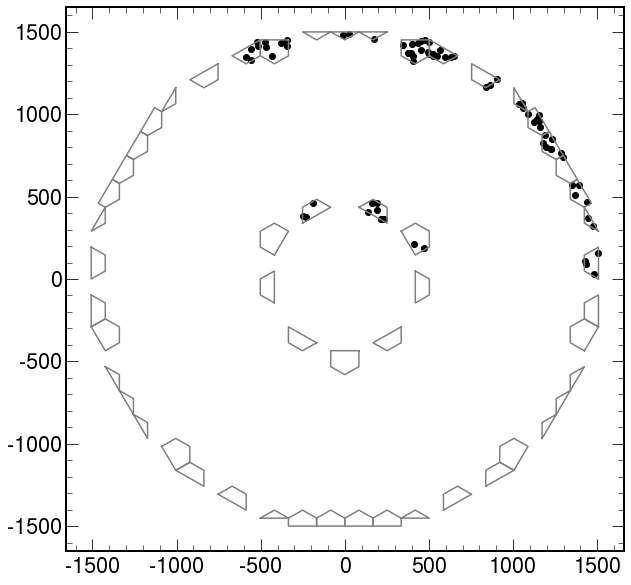

In [4]:
def isPointIn(x,y,row):
    
    """
    point-in-polygon through path approach
    given modules are convex polygons, do a path starting from the first vertex and
    check if the point in question is always on the same side
    https://www.eecs.umich.edu/courses/eecs380/HANDOUTS/PROJ2/InsidePoly.html (solution 3)
    """

    delta_sign=None
    nverts=int(row['nvertices'])
    for i in range(nverts+1):
        i0=i%(nverts+1)
        i1=(i+1)%(nverts)
        idelta=(y-row[f'vy_{i0}'])*(row[f'vx_{i1}']-row[f'vx_{i0}'])
        idelta-=(x-row[f'vx_{i0}'])*(row[f'vy_{i1}']-row[f'vy_{i0}'])
        idelta_sign=np.sign(idelta)
        if delta_sign is None: delta_sign=idelta_sign
        if idelta_sign != delta_sign : return False
    return True

#test algorithm
def testIsPointIn(n=5000,layer=1):
    plane_df=geom_df[(geom_df['plane']==layer)]
    fig,ax=plt.subplots()
    x = np.random.randint(-2000,2000,n)
    y = np.random.randint(-2000,2000,n)
    for i in range(n):
        for _,row in plane_df.iterrows():
            isIn=isPointIn(x[i],y[i],row)
            if not isIn: continue
            plt.scatter(x[i],y[i],color='k')
            break
    showModulesInPlane(layer,-1,geom_df,ax)
    plt.show()
    
geom_df=pd.read_csv('../data/geometry.hgcal.txt', sep='\s+', comment='#', header='infer')
mask=~geom_df['itype'].str.contains('F',regex=False)
geom_df=geom_df[mask][['plane','u','v','nvertices']+[f'v{x}_{i}' for i in range(7) for x in 'xy'] ]
geom_df.head()
testIsPointIn(layer=37)

## 2. Mask generator for hadronic energy studies

Filters out the partials and creates the mask files with the vertices to be used to filter out DetIds in the CMSSW geometry

In [5]:
cols=['plane','u','v','nvertices']+[f'v{x}_{i}' for i in range(7) for x in 'xy']

#generate geometry masks for CMSSW analyzer
url='../data/geometry.hgcal.txt'
geom_df=pd.read_csv(url, sep='\s+', comment='#', header='infer')
   
#select partials    
maskpartials=~geom_df['itype'].str.contains('F',regex=False)
geom_masks_df=geom_df[maskpartials].copy()
mask_url=url.replace('geometry','mask_geometry')
geom_masks_df[cols].to_csv(mask_url,
                           sep=' ', 
                           header=True,
                           index=False,
                            float_format='%.3f')
    
#select 3's and set all vertices to 0 so they can be always vetoed
geom_nothrees_masks_df=geom_masks_df.copy()
mask3=geom_nothrees_masks_df['itype'].str.contains('c',regex=False)
geom_nothrees_masks_df.loc[mask3,'nvertices']=0
for i in range(7):
    for x in 'xy':
        geom_nothrees_masks_df.loc[mask3,f'v{x}_{i}'] = 0.
geom_nothrees_masks_df[cols].to_csv(mask_url.replace('.hgcal.','.nothrees.hgcal.'),
                                    sep=' ', 
                                    header=True,
                                    index=False,
                                    float_format='%.3f')

#no fives geometry : masks need to be complemented with the 3's from base geometry
url='../data/geometry.nofives.hgcal.txt'
geom_nofives_df=pd.read_csv(url, sep='\s+', comment='#', header='infer')

#Philippe has rotated this layers but the convention is to have them unrotated
dphi=-np.pi/6.
for layer in [28,30,32]: 
    mask=(geom_nofives_df['plane']==layer)
    for i in range(0,7):
        vx=geom_nofives_df.loc[mask,f'vx_{i}']
        vy=geom_nofives_df.loc[mask,f'vy_{i}']
        geom_nofives_df.loc[mask,f'vx_{i}']=vx*np.cos(dphi)-vy*np.sin(dphi)
        geom_nofives_df.loc[mask,f'vy_{i}']=vx*np.sin(dphi)+vy*np.cos(dphi)
        
maskpartials_nofives=~geom_nofives_df['itype'].str.contains('F',regex=False)
geom_nofives_masks_df=geom_nofives_df[maskpartials_nofives].copy()
geom_nofives_masks_df=pd.concat([geom_nofives_masks_df,geom_masks_df[mask3]])

#set number of vertices to 0 for threes
mask3=geom_nofives_masks_df['itype'].str.contains('c',regex=False)
geom_nofives_masks_df.loc[mask3,'nvertices']=0
for i in range(7):
    for x in 'xy':
        geom_nofives_masks_df.loc[mask3,f'v{x}_{i}'] = 0.
mask_url=url.replace('geometry','mask_geometry')
geom_nofives_masks_df[cols].to_csv(mask_url,
                                   sep=' ', 
                                   header=True,
                                   index=False,
                                   float_format='%.3f')

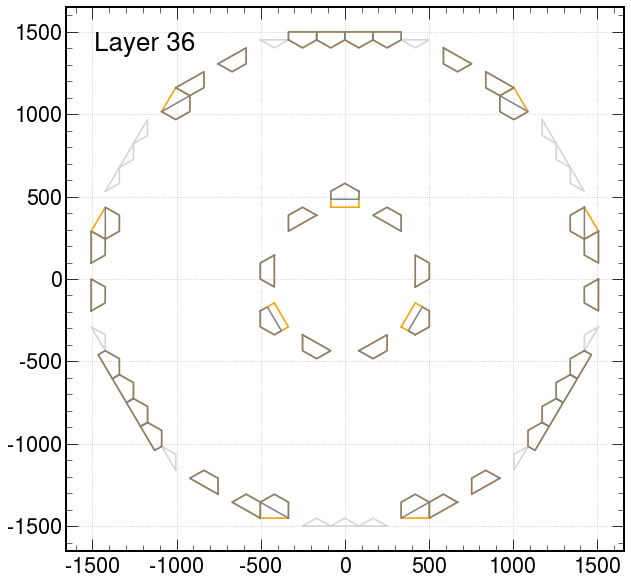

In [6]:
fig,ax = plt.subplots()
plane=36
showModulesInPlane(plane,1,geom_masks_df,ax,color='lightgray') 
showModulesInPlane(plane,1,geom_nothrees_masks_df,ax,color='orange')
showModulesInPlane(plane,1,geom_nofives_masks_df,ax,color='gray')
plt.text(0.05,0.92,f'Layer {plane}',transform=ax.transAxes)
plt.grid()
plt.show()

## 3. Comparison with masks implemented at ntuplizer level

Open a geometry ntuple and plots the filtered out detids

In [56]:
import ROOT
import os

#rfile='/eos/user/p/psilva/www/HGCAL/K0L/output_tmp.root'
#outdir='/eos/user/p/psilva/www/HGCAL/K0L/masks'
rfile='/eos/user/p/psilva/HGCal/output_d88_12_4_0_pre4_double_largertol_fix.root'
outdir='/eos/user/p/psilva/www/HGCAL/K0L/d88_12_5_0_pre5'
os.system(f'mkdir -p {outdir}')
geom_df=pd.read_csv('../data/geometry.hgcal.txt', sep='\s+', comment='#', header='infer')

In [57]:
for dname,name in [('ana','base'), 
                  # ('ana_no3','no3'),
                  # ('ana_no5','no5')
                  ]:

    print('Starting plots for',name)
    r=ROOT.RDataFrame(f'{dname}/coord',rfile)
    d=pd.DataFrame(r.AsNumpy())
    d=d.astype({'plane': 'int32','wu':'int32','wv':'int32','u':'int32','v':'int32','veto':'int32'})
    d.head()

    #loop over all the layers
    for layer in range(1,48):
        fig,ax=plt.subplots(1,2,figsize=(24,12))
        for i in range(2):
            side=-1 if i==0 else 1
            mask=(d['plane']==layer)
            if side>0 : mask &= (d['z']>0)
            else : mask &= (d['z']<0)    
            mask_veto=mask & (d['veto']==1)

            ax[i].scatter(d[mask]['x']*10,d[mask]['y']*10,marker=1,s=2,label='keep (blue)',color='blue')
            ax[i].scatter(d[mask_veto]['x']*10,d[mask_veto]['y']*10,marker='o',s=15,label='veto (orange)',color='orange')
            if mask_veto.sum()>0:
                print(layer,i,'has',mask_veto.sum(),'extra hits?')
                print(d[mask_veto][['plane','u','v','wu','wv','x','y']].head())
                print('-'*50)
            showModulesInPlane(layer,side,geom_df,ax[i])
            ax[i].set_xlabel('x [cm]')
            ax[i].set_ylabel('y [cm]')
            ax[i].set_title(f'Layer {side*layer:+}')
            ax[i].legend(loc='lower right',fontsize=12)
            ax[i].grid()

            if i==0:
                ax[i].text(0.05,0.95,'Boundaries of the baseline geometry are superimposed',fontsize=14,transform=ax[i].transAxes)
                ax[i].text(0.05,0.05,f'Select/veto points for {name} geometry',fontsize=14,transform=ax[i].transAxes)
                if mask_veto.sum()>0:
                    ax[i].text(0.05,0.025,f'{mask_veto.sum()} extra points found?',fontsize=14,transform=ax[i].transAxes)
                
        plt.tight_layout()   
        plt.savefig(f'{outdir}/{dname}_layer_{layer}.png')
        plt.close()  

Starting plots for base
1 0 has 2675 extra hits?
        plane   u   v  wu  wv          x         y
811878      1   4  15   2   0  30.945314 -7.607492
811879      1   5  15   2   0  30.945314 -6.806704
811880      1   6  15   2   0  30.945314 -6.005915
811881      1  21  15   2   0  30.945314  6.005915
811882      1  22  15   2   0  30.945314  6.806704
--------------------------------------------------
1 1 has 2675 extra hits?
     plane   u   v  wu  wv          x         y
288      1   4  15   2   0 -30.945314 -7.607492
289      1   5  15   2   0 -30.945314 -6.806704
290      1   6  15   2   0 -30.945314 -6.005915
291      1  21  15   2   0 -30.945314  6.005915
292      1  22  15   2   0 -30.945314  6.806704
--------------------------------------------------
2 0 has 3918 extra hits?
        plane   u   v  wu  wv          x         y
843093      2   4  15   2   0  30.945314 -7.607492
843094      2   5  15   2   0  30.945314 -6.806704
843095      2   6  15   2   0  30.945314 -6.005915
8

12 0 has 3036 extra hits?
         plane   u   v  wu  wv          x         y
1155243     12   4  15   2   0  30.945314 -7.607492
1155244     12   5  15   2   0  30.945314 -6.806704
1155245     12   6  15   2   0  30.945314 -6.005915
1155246     12  21  15   2   0  30.945314  6.005915
1155247     12  22  15   2   0  30.945314  6.806704
--------------------------------------------------
12 1 has 3036 extra hits?
        plane   u   v  wu  wv          x         y
343653     12   4  15   2   0 -30.945314 -7.607492
343654     12   5  15   2   0 -30.945314 -6.806704
343655     12   6  15   2   0 -30.945314 -6.005915
343656     12  21  15   2   0 -30.945314  6.005915
343657     12  22  15   2   0 -30.945314  6.806704
--------------------------------------------------
13 0 has 2034 extra hits?
         plane   u   v  wu  wv          x         y
1186458     13   4  15   2   0  30.945314 -7.607492
1186459     13   5  15   2   0  30.945314 -6.806704
1186460     13   6  15   2   0  30.945314 -6.0

23 0 has 3309 extra hits?
         plane   u   v  wu  wv          x         y
1498608     23   4  15   2   0  30.945314 -7.607492
1498609     23   5  15   2   0  30.945314 -6.806704
1498610     23   6  15   2   0  30.945314 -6.005915
1498611     23  21  15   2   0  30.945314  6.005915
1498612     23  22  15   2   0  30.945314  6.806704
--------------------------------------------------
23 1 has 3309 extra hits?
        plane   u   v  wu  wv          x         y
687018     23   4  15   2   0 -30.945314 -7.607492
687019     23   5  15   2   0 -30.945314 -6.806704
687020     23   6  15   2   0 -30.945314 -6.005915
687021     23  21  15   2   0 -30.945314  6.005915
687022     23  22  15   2   0 -30.945314  6.806704
--------------------------------------------------
24 0 has 3792 extra hits?
         plane   u   v  wu  wv          x         y
1529823     24   4  15   2   0  30.945314 -7.607492
1529824     24   5  15   2   0  30.945314 -6.806704
1529825     24   6  15   2   0  30.945314 -6.0

34 0 has 1565 extra hits?
         plane   u  v  wu  wv          x          y
4411444     34  11  8   3   1  41.166698   8.437149
4411445     34  12  8   3   1  41.166698   9.638331
4411446     34  13  8   3   1  41.166698  10.839515
4411447     34  14  8   3   1  41.166698  12.040698
4411448     34  15  8   3   1  41.166698  13.241880
--------------------------------------------------
34 1 has 1565 extra hits?
         plane   u  v  wu  wv          x          y
4330804     34  11  8   3   1 -41.166698   8.437149
4330805     34  12  8   3   1 -41.166698   9.638331
4330806     34  13  8   3   1 -41.166698  10.839515
4330807     34  14  8   3   1 -41.166698  12.040698
4330808     34  15  8   3   1 -41.166698  13.241880
--------------------------------------------------
35 0 has 1605 extra hits?
         plane  u   v  wu  wv          x          y
4421263     35  2   9   3   1  40.126442  16.360308
4421277     35  3  10   3   1  39.086185  16.960899
4421278     35  4  10   3   1  39.086185

45 0 has 1191 extra hits?
         plane  u   v  wu  wv          x          y
4463772     45  3   7   1   3  -8.025289  47.764271
4463797     45  4   9   1   3 -10.105799  47.764271
4463809     45  4  10   1   3 -11.146053  47.163681
4463821     45  5  11   1   3 -12.186308  47.764271
4463832     45  5  12   1   3 -13.226563  47.163681
--------------------------------------------------
45 1 has 1191 extra hits?
         plane  u   v  wu  wv          x          y
4383132     45  3   7   1   3   8.025289  47.764271
4383157     45  4   9   1   3  10.105799  47.764271
4383169     45  4  10   1   3  11.146053  47.163681
4383181     45  5  11   1   3  12.186308  47.764271
4383192     45  5  12   1   3  13.226563  47.163681
--------------------------------------------------
46 0 has 1128 extra hits?
         plane  u  v  wu  wv          x          y
6079732     46  1  8   3   0  49.538738 -18.075480
6079733     46  2  8   3   0  49.538738 -16.874298
6079734     46  3  8   3   0  49.538738 -15

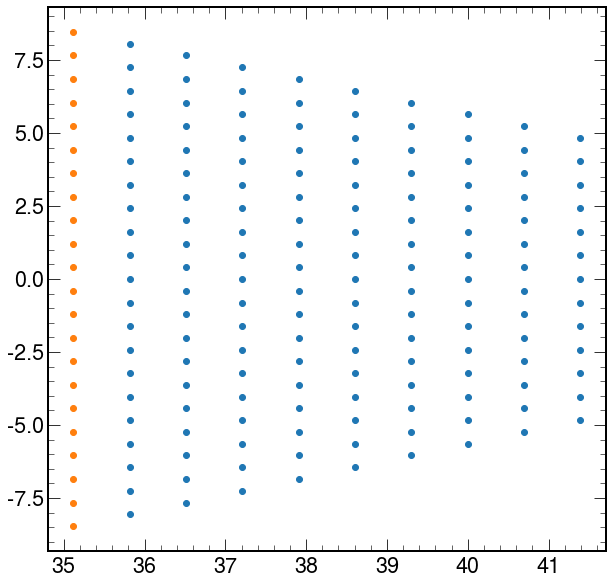

In [51]:
mask=(d['plane']==33) & (d['wu']==2) & (d['wv']==0) & (d['x']>0) & (d['veto']==0)
plt.scatter(d[mask]['x'],d[mask]['y'])
mask=(d['plane']==33) & (d['wu']==2) & (d['wv']==0) & (d['x']>0) & (d['veto']==1)
plt.scatter(d[mask]['x'],d[mask]['y'])

plt.show()

## 4. Acceptance

Use toys to shoot from (0,0,0) and check how many layers are expected to have Si hits.
Separate CE-E from CE-H.

In [9]:
geom_df=pd.read_csv('../data/geometry.hgcal.txt', sep='\s+', comment='#', header='infer')

#mask 3
#mask3=geom_df['itype'].str.contains('c',regex=False)
#geom_df=geom_df[~mask3]
#print(mask3.sum(),'have been masked')

#full geometry
corr_geom_df=getCorrectedFullGeometry(geom_df) #negative side geometry
corr_geom_df.head()

plane         z  nvertices        vx_0        vx_1        vx_2        vx_3  \
0      1 -3221.455          5  -83.718000  -83.729000   83.695000   83.705000   
1      1 -3221.455          5 -251.200533 -232.300090 -315.999966 -334.899908   
2      1 -3221.455          5  334.918533  316.029090  232.304966  251.194908   
3      1 -3221.455          6    0.047000   -0.018000  -83.763000 -167.442000   
4      1 -3221.455          6 -334.899935 -418.599967 -418.599796 -334.900092   

         vx_4        vx_5        vx_6        vy_0        vy_1        vy_2  \
0    0.047000  -83.718000    0.000000  338.396000  316.578000  316.564000   
1 -334.899935 -251.200533   -0.000000 -241.699915 -230.800441  -85.800004   
2  334.852935  334.918533    0.000000  -96.696085  -85.777559 -230.763996   
3 -167.463000  -83.718000    0.047000  386.682000  483.368000  531.718000   
4 -251.200361 -251.200533 -334.899935 -193.300297 -241.699588 -338.399886   

         vy_3        vy_4        vy_5        vy_6  
0  338.382000  386.682000  338.396000    0.000000  
1  -96.700344 -193.300297 -241.699915    0.000000  
2 -241.681656 -193.381703  -96.696085   -0.000000  
3  483.382000  386.746000  338.396000  386.682000  
4 -386.700026 -338.400212 -241.699915 -193.300297

In [10]:
#make a rectangular scan in eta, phi
n=50
eta_bins=np.linspace(1.4,3.1,n)
eta_cen=0.5*(eta_bins[1:]+eta_bins[0:-1])
phi_bins=np.linspace(-np.pi,np.pi,n)
phi_cen=0.5*(phi_bins[1:]+phi_bins[0:-1])
eta,phi=[],[]
for x in eta_cen:
    for y in phi_cen:
        eta.append(x)
        phi.append(y)

acceptance=[]
for i in range(len(eta)):

    if i%n==0 : print(f'{i}/{len(eta)}')
        
    #find hits in each plane
    hasHits=np.array(47*[0],dtype=bool)
    for plane,group in corr_geom_df.groupby('plane'):
        
        #project in the transverse plane at the z of this plane
        z=group.iloc[0]['z']
        rho=z/np.sinh(-eta[i])
        x = rho*np.cos(phi[i])
        y = rho*np.sin(phi[i])
        
        #find first hit
        for _,row in group.iterrows():
            if not isPointIn(x,y,row): continue
            hasHits[plane-1]=True
            break
    
    #total hits in CE-E, CE-H and HGCAL
    nHits_CEE=hasHits[0:26].sum()
    nHits_CEH=hasHits[26:].sum()
    nHits=nHits_CEE+nHits_CEH
    
    #add row 
    acceptance.append([eta[i],phi[i],nHits,nHits_CEE,nHits_CEH]+hasHits.tolist())
        

acceptance.to_hdf('baseline.h5',key='data')
acceptance=pd.DataFrame(acceptance,columns=['eta','phi','n','ncee','nceh']+[f'l{i+1}' for i in range(47)])
acceptance.head()

0/2401
50/2401
100/2401
150/2401
200/2401
250/2401
300/2401
350/2401
400/2401
450/2401
500/2401
550/2401
600/2401
650/2401
700/2401
750/2401
800/2401
850/2401
900/2401
950/2401
1000/2401
1050/2401
1100/2401
1150/2401
1200/2401
1250/2401
1300/2401
1350/2401
1400/2401
1450/2401
1500/2401
1550/2401
1600/2401
1650/2401
1700/2401
1750/2401
1800/2401
1850/2401
1900/2401
1950/2401
2000/2401
2050/2401
2100/2401
2150/2401
2200/2401
2250/2401
2300/2401
2350/2401
2400/2401


eta       phi  n  ncee  nceh     l1     l2     l3     l4     l5  ...  \
0  1.417347 -3.077479  1     1     0  False  False  False  False  False  ...   
1  1.417347 -2.949250  1     1     0  False  False  False  False  False  ...   
2  1.417347 -2.821022  1     1     0  False  False  False  False  False  ...   
3  1.417347 -2.692794  1     1     0  False  False  False  False  False  ...   
4  1.417347 -2.564565  1     1     0  False  False  False  False  False  ...   

     l38    l39    l40    l41    l42    l43    l44    l45    l46    l47  
0  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  False  False  

[5 rows x 52 columns]

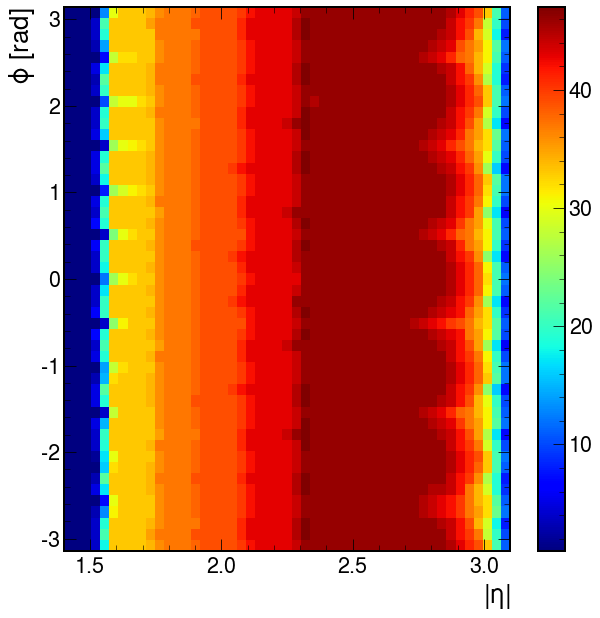

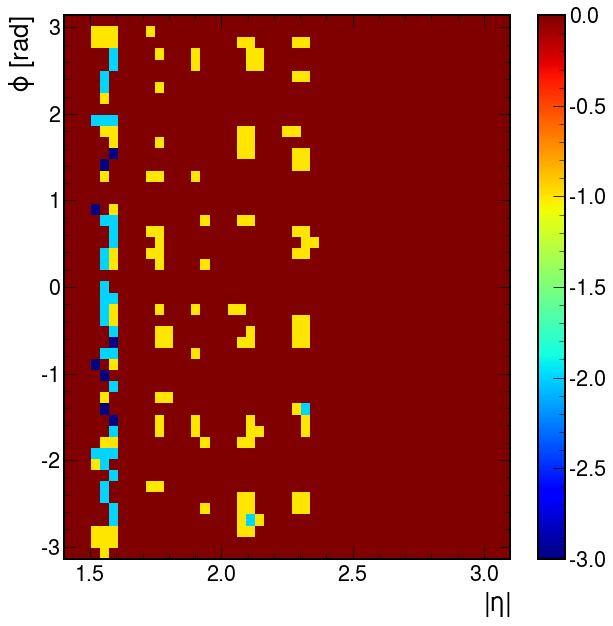

In [47]:
acc_baseline=pd.read_hdf('baseline.h5',key='data')
acc_no3=pd.read_hdf('no3.h5',key='data')

acc_merged=acc_baseline.join(acc_no3, 
                             how = 'inner', 
                             lsuffix='', 
                             rsuffix='_no3')
acc_merged.reset_index(inplace=True)
acc_merged['n_no3']-=acc_merged['n']

fig,ax=plt.subplots(figsize=(10,10))
hbase=ax.hist2d(acc_merged['eta'],
                acc_merged['phi'],
                weights=acc_merged['n'],
                bins=(eta_bins,phi_bins),
                cmap='jet', cmin=0)
ax.set_xlabel(r'$|\eta|$')
ax.set_ylabel(r'$\phi$ [rad]')
fig.colorbar(hbase[3], ax=ax)
plt.show()


fig,ax=plt.subplots(figsize=(10,10))
hno3=ax.hist2d(acc_merged['eta'],
                acc_merged['phi'],
                weights=acc_merged['n_no3'],
                bins=(eta_bins,phi_bins),
                cmap='jet') #, cmin=0)
ax.set_xlabel(r'$|\eta|$')
ax.set_ylabel(r'$\phi$ [rad]')
fig.colorbar(hno3[3], ax=ax)
plt.show()
plt.close()
